In [5]:
path = ""

def mount():
    global path
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/Colab Notebooks/컴퓨터비전/TeamProject/"

def local():
    global path
    path = "./resources/"

In [6]:
# mount()
local()

In [7]:
import scipy.io as io
import numpy as np

# load the data
data = io.loadmat(path + "face_landmark.mat")
images = data["images"]
landmarks = data["landmarks"]
print("im_shape:", images.shape)
print("landmarks_shape:", landmarks.shape)

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


### (1) Dataset visualization:

* Describe your goal
* Visualize a few random images
* Also mark the corresponding keypoints/landmarks on each image

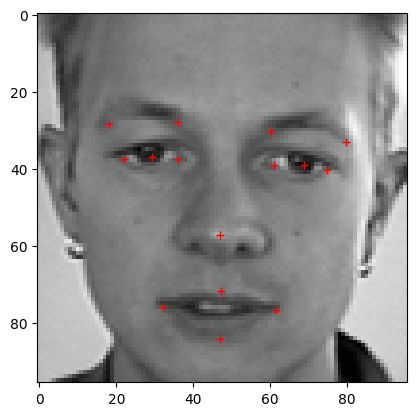

In [4]:
# visualize a random data
np.random.seed(101)
id = np.random.randint(len(images))
im = images[id]
keypoints = landmarks[id]

from matplotlib import pyplot as plt

plt.imshow(im, cmap="gray")
for point in keypoints:
    plt.plot(point[0], point[1], "r+")
plt.show()

### (2) Preprocessing (if any):

* E.g., normalization, reshaping, etc.

In [ ]:
# randomly split into train (0.6), val(0.2), test(0.2)
np.random.seed(101)
n = len(landmarks[0])
idx = np.random.permutation(n)
nTrain = int(0.6 * n)
nTrainVal = int((0.6 + 0.2) * n)
Xtrain, Ytrain = images[:nTrain], landmarks[:nTrain]
Xval, Yval = images[nTrain:nTrainVal], landmarks[nTrain:nTrainVal]
Xtest, Ytest = images[nTrainVal:], landmarks[nTrainVal:]

In [ ]:
image_width = im.shape[1]

# Normalize pixel values to the range of [0, 1]
Xtrain = Xtrain / 255.0
Xval = Xval / 255.0
Xtest = Xtest / 255.0

# Normalize landmark coordinates to the range of [0, 1]
Ytrain = Ytrain / image_width  # Assuming image_width is the width of the input images
Yval = Yval / image_width
Ytest = Ytest / image_width


### (3) Network structure:

* Describe and draw

In [ ]:
import tensorflow as tf

regularizer = tf.keras.regularizers.L2(0.01)  # 람다가 0.01인 regularizer

x_in = x = tf.keras.Input(shape=[96, 96, 1])

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=64, activation="relu", kernel_regularizer=regularizer)(x)

# x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(units=30, kernel_regularizer=regularizer)(x)

y = x = tf.keras.layers.Reshape((15, 2))(x)

model = tf.keras.Model(inputs=x_in, outputs=y)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        1849

In [ ]:
""" build the predictor function """


@tf.function
def predict(x):
    return model(x)

### (4) - Loss Functions:

* L2-loss
* L1-loss
* cosine-loss
  + X에 대한 코사인 유사도와 Y에 대한 코사인 유사도 따로 따로 확인 (X와 Y는 독립 변수이므로)
* Can you combine two loss functions to better the performance, 
  + e.g. L2-loss+ lamda*cosine-loss.


In [ ]:
""" define loss function """


@tf.function
def loss_fn(y, y_true):
    l2_loss = tf.reduce_mean(tf.square(y - y_true))
    return l2_loss

### (5) Results:

* Validation performance comparison:
  + For different loss functions
  + For different lamda values (if you combined loss-functions)
  + For different regularization
  + For dropout/ no-dropout

* Final performance on test set:
  * Present prediction error
  * And visualize a few good prediction, and a few bad prediction
* Present your discussion 


In [ ]:
""" define the optimization step"""
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)


@tf.function
def optimize(x, y_true):
    with tf.GradientTape() as tape:
        y = predict(x)
        loss = loss_fn(y, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [ ]:
""" start training """
max_epochs = 1000
batch_size = 32

loss_history = []
val_loss_best = np.inf
for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(nTrain)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(Xtrain[batch_idx], Ytrain[batch_idx])
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(Xval)
    val_loss = loss_fn(y, Yval).numpy()
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        #model.save_weights('net_best')
    print(epoch, '.', train_loss, val_loss, val_loss_best)
    loss_history.append([train_loss, val_loss])


0 . 0.028765049 0.12806721 0.12806721
1 . 0.114606194 0.02524071 0.02524071
2 . 0.021042095 0.038742676 0.02524071
3 . 0.036616366 0.058053635 0.02524071
4 . 0.05663673 0.06483689 0.02524071
5 . 0.06379105 0.060604017 0.02524071
6 . 0.059668683 0.048649244 0.02524071
7 . 0.0475925 0.03289469 0.02524071
8 . 0.031431448 0.01921571 0.01921571
9 . 0.016844302 0.015639467 0.015639467
10 . 0.011622366 0.025704974 0.015639467
11 . 0.019553144 0.03618481 0.015639467
12 . 0.028636701 0.03282352 0.015639467
13 . 0.025470605 0.020990336 0.015639467
14 . 0.014942007 0.012104824 0.012104824
15 . 0.0075521832 0.00992751 0.00992751
16 . 0.0065226415 0.011897409 0.00992751
17 . 0.009194952 0.014461824 0.00992751
18 . 0.012138671 0.015507424 0.00992751
19 . 0.013314153 0.014442306 0.00992751
20 . 0.012176985 0.011793158 0.00992751
21 . 0.009274006 0.0088100135 0.0088100135
22 . 0.0058598714 0.0070006377 0.0070006377
23 . 0.0034669857 0.007368768 0.0070006377
24 . 0.0031718214 0.009460563 0.0070006377
2

In [ ]:
""" evalute on test test"""
# load the best network
#model.load_weights('net_best')

# predict and evaluate
p = model.predict(Xtest)

mse = tf.reduce_mean(tf.square(p - Ytest))

print("Mean Squared Error :", mse)

67/67 [==============================] - 16s 236ms/step
Mean Squared Error : 0.0031949414
